# Crypto Sentiment on Chart Analysis

This notebook aims to explore the potential relationship between sentiment on 4chan's Business and Finance board and the price action of selected cryptocurrencies. 4chan is a valuable source for sentiment analysis as its posts are freely accessible via its API, making it a cost-effective alternative to platforms like Twitter. The primary objective of this analysis is to investigate whether sentiment derived from 4chan posts can be correlated with the price movements of specific cryptocurrencies. By binning 4chan posts into specific time intervals and aligning them with cryptocurrency price charts, we can calculate a net sentiment score for each bin and observe any patterns or trends that may emerge. Here's how it works:

- **Data Collection**: Scrape 4chan thread posts related to cryptocurrencies, focusing on the Business and Finance board. Then, organise the posts in chronological order.
- **Datetime Binning**: Slot the post data into predefined datetime bins that correspond to intervals on a cryptocurrency price chart.
- **Sentiment Analysis**: Perform sentiment analysis on the text data within each bin to categorize posts as bullish, neutral, or bearish.
Sum the sentiment scores within each bin to generate a net sentiment score.
- **Net Sentiment Score Calculation**: Calculate the net average sentiment score by subtracting the bearish sentiment score from the bullish sentiment score and then dividing with the number of predictions. A positive net sentiment score indicates a bullish sentiment, while a negative score indicates bearish sentiment.
- **Analysis**: Compare the net sentiment scores with the corresponding price action in the cryptocurrency market. Investigate whether there is a discernible relationship between the sentiment on 4chan and the subsequent price movements.

In this notebook, this analysis is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs and thread post data from 4chan's Business and Finance board.

## Prepare your Environment

Ensure that the 'venv' kernel is selected for this notebook. If not, click on 'Kernel' at the top bar, select 'Change Kernel...' and select 'crypto-trading-analysis' as the kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [ ]:
pip install -r requirements.txt

## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data, save_sentiment_score_df, load_presaved_df
from social_media_analysis.data_manager import load_df_range as load_post_df_range

/Users/gordon.oh/miniconda3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/gordon.oh/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/gordon.oh/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- All available pairs will be loaded by default.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N volume pairs using the ***top_n_volume_pairs*** parameter.
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

### Inputs

In [2]:
##### INPUTS #####
cex = 'binance'
interval = '1d'
nan_remove_threshold = 0.1

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 100

# Select volume filter mode. Options: ['rolling', 'mean'].
volume_filter_mode = 'rolling'
##################

In [3]:
print("\nMode: Crypto Sentiment on Chart Analysis")
print("CEX: {}".format(str(cex).capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))
print("Volume Filter Mode: {}".format(str(volume_filter_mode).capitalize()))

merged_price_df = process_data('sentiment_on_chart', cex, interval, nan_remove_threshold, [],
                 top_n_volume_pairs, volume_filter_mode)

print("\n")


Mode: Crypto Sentiment on Chart Analysis
CEX: Binance
Interval: 1d
NaN Remove Threshold: 0.1
Top N Volume Pairs: 100
Volume Filter Mode: Rolling

Columns that contains NaN values:
              Pair  NaN Count          Remark
39         SUNUSDT        729       To Remove
67      POPCATUSDT        729       To Remove
69      ALPACAUSDT        729       To Remove
155      BRETTUSDT        727       To Remove
108      VOXELUSDT        727       To Remove
137        SYSUSDT        726       To Remove
144        SYNUSDT        723       To Remove
124       RAREUSDT        722       To Remove
138          GUSDT        722       To Remove
98      BANANAUSDT        722       To Remove
102     RENDERUSDT        702       To Remove
21         ZROUSDT        666       To Remove
111      LISTAUSDT        666       To Remove
30          ZKUSDT        663       To Remove
6          MEWUSDT        663       To Remove
116         IOUSDT        657       To Remove
80       TURBOUSDT        645       T

## Sanitize the price dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

### Inputs

In [4]:
##### INPUTS #####
start_date = '2022-08-24'
end_date = '2024-08-22'
##################

In [5]:
print("\n")

price_data_sanitized, sorted_available_pairs = sanitize_data(merged_price_df, start_date, end_date)

if price_data_sanitized:
    print("-Data Check-")
    keys = list(price_data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, price_data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (730, 1)
ETHUSDT's Data Shape: (730, 1)




## Process Post Dataframe

- Select the post data source. As of now, the only available options are *4chan* and *hugging_face*.
   - To download 4chan's data, change directory into the ***'social_media_analysis'*** folder and run ***'python data_manager.py'*** in the terminal first.
   - To download Hugging Face's data, change directory into the ***'social_media_analysis'*** folder and run ***'python download_hugging_face_data.py'*** in the terminal first.
   - To download Telegram Channel's data, change directory into the ***'social_media_analysis'*** folder and run ***'python scrape_telegram_data.py'*** in the terminal first.
- Write the relative directory path to the data from the current location to ***dir_path*** (eg. './social_media_analytics/saved_data/4chan/biz').

### Inputs

In [11]:
##### INPUTS #####
# Select data source. Options: ['4chan', 'hugging_face', 'telegram'].
source = 'telegram'

# Select source tag. Eg. 'biz' (source = '4chan'), '-1001164734593-SpiderCrypto Trading Journal' (source = 'telegram')
tag = '-1001164734593-SpiderCrypto Trading Journal'
##################

In [12]:
dir_path = './social_media_analysis/saved_data/{}/{}'.format(source, tag)
merged_post_df = load_post_df_range(dir_path, source, start_date, end_date)

merged_post_df.head(10)

,Date Time,Comment UUID,Chat ID,Chat Title,User ID,Username,Comment
0,2023-02-04 09:45:16,-1001164734593-1115,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,doge coins popping off up 10% <— best perp for...
1,2023-02-04 14:58:42,-1001164734593-1116,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,i still think february is a bullish month. cob...
2,2023-02-04 19:32:29,-1001164734593-1117,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,some of y’all were afraid of buying the top of...
3,2023-02-04 19:48:27,-1001164734593-1118,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,this list has been fucken killer
4,2023-02-04 19:50:13,-1001164734593-1119,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,"shilled , , , on jan 20th hami 3x jones 30% 2x..."
5,2023-02-04 20:16:11,-1001164734593-1120,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,damn anime nft that partnered with toei animat...
6,2023-02-05 02:06:51,-1001164734593-1125,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,slept hard on this one. . it's currently up 4x...
7,2023-02-05 02:34:56,-1001164734593-1127,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,"closed doge position for now, will recalibrate..."
8,2023-02-06 05:40:32,-1001164734593-1129,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,crazy to see checks still running
9,2023-02-06 05:40:45,-1001164734593-1130,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,surprising amount of people want that single c...


In [13]:
_, sample_price_df = next(iter(price_data_sanitized.items()))
bin_datetime_df = pd.DataFrame(sample_price_df.index)
bin_datetime_df.columns = ['Binned Date Time']

In [14]:
# Use pd.merge_asof to align to bin_datetime_df
post_data_binned_df = pd.merge_asof(merged_post_df, bin_datetime_df, left_on='Date Time', right_on='Binned Date Time')
post_data_binned_df['Date Time'] = post_data_binned_df['Binned Date Time']
post_data_binned_df = post_data_binned_df.drop(columns=['Binned Date Time'])
post_data_binned_df = post_data_binned_df.dropna(subset=['Date Time'])
post_data_binned_df.head(10)

,Date Time,Comment UUID,Chat ID,Chat Title,User ID,Username,Comment
0,2023-02-04,-1001164734593-1115,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,doge coins popping off up 10% <— best perp for...
1,2023-02-04,-1001164734593-1116,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,i still think february is a bullish month. cob...
2,2023-02-04,-1001164734593-1117,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,some of y’all were afraid of buying the top of...
3,2023-02-04,-1001164734593-1118,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,this list has been fucken killer
4,2023-02-04,-1001164734593-1119,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,"shilled , , , on jan 20th hami 3x jones 30% 2x..."
5,2023-02-04,-1001164734593-1120,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,damn anime nft that partnered with toei animat...
6,2023-02-05,-1001164734593-1125,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,slept hard on this one. . it's currently up 4x...
7,2023-02-05,-1001164734593-1127,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,"closed doge position for now, will recalibrate..."
8,2023-02-06,-1001164734593-1129,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,crazy to see checks still running
9,2023-02-06,-1001164734593-1130,-1001164734593,SpiderCrypto Trading Journal,-1001164734593,spidersjournal,surprising amount of people want that single c...


## Load Pre-saved Sentiment Scores 

The purpose of this section is to identify which datetimes already have sentiment scores. If a datetime has a score, the LLM will skip performing sentiment analysis for that datetime. This helps to save time.

In [28]:
print("\n")

presaved_sentiment_score_df_base = pd.DataFrame(columns=['Open Time', 'Sentiment Score'])
sentiment_score_dir_path = './saved_data/sentiment_score/{}/{}/{}'.format(source, tag, cex + '_' + interval)
normalised_sentiment_score_dir_path = './saved_data/normalised_sentiment_score/{}/{}/{}'.format(source, tag, cex + '_' + interval)

presaved_sentiment_score_df, _ = load_presaved_df(presaved_sentiment_score_df_base, sentiment_score_dir_path)
presaved_normalised_sentiment_score_df, _ = load_presaved_df(presaved_sentiment_score_df_base, normalised_sentiment_score_dir_path)

print("Presaved Sentiment Score:")
print(presaved_sentiment_score_df.tail(5))
print("\n")
print("Presaved Normalised Sentiment Score:")
print(presaved_normalised_sentiment_score_df.tail(5))

presaved_sentiment_score_datetime_dict = pd.Series(True, index=presaved_sentiment_score_df['Open Time']).to_dict()
presaved_normalised_sentiment_score_datetime_dict = pd.Series(True, index=presaved_normalised_sentiment_score_df['Open Time']).to_dict()

overlapped_datetime = set(presaved_sentiment_score_datetime_dict.keys()).intersection(presaved_normalised_sentiment_score_datetime_dict.keys())
overlapped_presaved_datetime_dict = {datetime: True for datetime in overlapped_datetime}

print("\n")



Presaved Sentiment Score:
     Open Time  Sentiment Score
425 2024-08-18         0.641968
426 2024-08-19         0.690363
427 2024-08-20         1.357739
428 2024-08-21         1.315479
429 2024-08-22         1.490428


Presaved Normalised Sentiment Score:
     Open Time  Sentiment Score
425 2024-08-18         0.320984
426 2024-08-19         0.172591
427 2024-08-20         0.452580
428 2024-08-21         0.657740
429 2024-08-22         0.496809




## Initialise LLM and Checking LLM Inputs

In [29]:
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3)
max_length = 128
pipe = TextClassificationPipeline(model=model,
                                  tokenizer=tokenizer,
                                  max_length=max_length,                           # original max_length is 64
                                  truncation=True,
                                  padding='max_length')

In [30]:
binned_datetime_comments_dict = {}
num_tokens_count_dict = {}

for _, row in post_data_binned_df.iterrows():
    bin_datetime = row['Date Time']
    bin_comment = row['Comment']
    tokens = tokenizer.tokenize(bin_comment)
    num_tokens = len(tokens)

    if num_tokens not in num_tokens_count_dict:
        num_tokens_count_dict[num_tokens] = 1
    else:
        num_tokens_count_dict[num_tokens] += 1
        
    if bin_datetime not in binned_datetime_comments_dict:
        binned_datetime_comments_dict[bin_datetime] = []

    binned_datetime_comments_dict[bin_datetime].append(bin_comment)

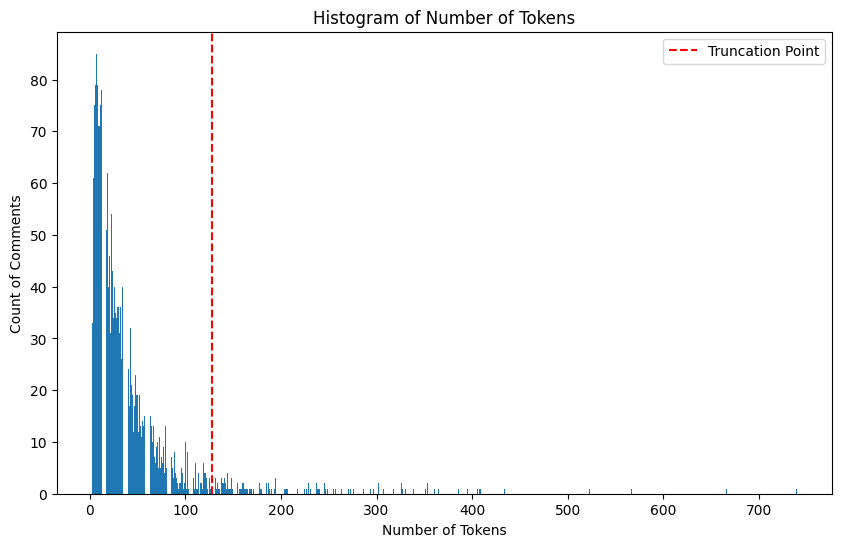

In [31]:
print("\n")

num_tokens = list(num_tokens_count_dict.keys())
counts = list(num_tokens_count_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(num_tokens, counts)
plt.axvline(x=max_length, color='red', linestyle='--', label='Truncation Point')

plt.xlabel('Number of Tokens')
plt.ylabel('Count of Comments')
plt.title('Histogram of Number of Tokens')
plt.legend()

plt.show()

print("\n")

## Use LLM to perform Sentiment Analysis

This part will take a while...

In [32]:
print("\n")

post_bin_datetime_list = []
post_bin_sentiment_score_list = []
post_bin_normalised_sentiment_score_list = []

for bin_datetime, comments in binned_datetime_comments_dict.items():

    if bin_datetime in overlapped_presaved_datetime_dict:
        continue

    print("Performing sentiment analysis on comments in Date Time {} bin...".format(bin_datetime))
    
    sentiment_preds = pipe(comments)
    bin_sentiment_score = 0
    
    for sentiment_pred in sentiment_preds:
        if sentiment_pred['label'].lower() == 'bullish':
            bin_sentiment_score += sentiment_pred['score']
        elif sentiment_pred['label'].lower() == 'bearish':
            bin_sentiment_score -= sentiment_pred['score']

    bin_normalised_sentiment_score = bin_sentiment_score / len(sentiment_preds)

    post_bin_datetime_list.append(bin_datetime)
    post_bin_sentiment_score_list.append(bin_sentiment_score)
    post_bin_normalised_sentiment_score_list.append(bin_normalised_sentiment_score)

print("\n")

## Save and Check Sentiment Score Data

### Sentiment Score

In [33]:
print("\n")

binned_sentiment_score_df = pd.DataFrame({
    'Open Time': post_bin_datetime_list,
    'Sentiment Score': post_bin_sentiment_score_list
})

binned_sentiment_score_df = save_sentiment_score_df(binned_sentiment_score_df, sentiment_score_dir_path, start_date, end_date)
binned_sentiment_score_df = binned_sentiment_score_df.set_index('Open Time')

print("Sentiment Score:")
print(binned_sentiment_score_df.head(5))
print(binned_sentiment_score_df.tail(5))

print("\n")



Deleted: ./saved_data/sentiment_score/telegram/-1001164734593-SpiderCrypto Trading Journal/binance_1d/2023-02-04 00:00:00_2024-08-22 00:00:00.pkl


Sentiment Score:
            Sentiment Score
Open Time                  
2023-02-04         2.013595
2023-02-05         0.553129
2023-02-06         0.000000
2023-02-07         1.505494
2023-02-08         1.313222
            Sentiment Score
Open Time                  
2024-08-18         0.641968
2024-08-19         0.690363
2024-08-20         1.357739
2024-08-21         1.315479
2024-08-22         1.490428




### Normalised Sentiment Score

In [34]:
print("\n")

binned_normalised_sentiment_score_df = pd.DataFrame({
    'Open Time': post_bin_datetime_list,
    'Sentiment Score': post_bin_normalised_sentiment_score_list
})

binned_normalised_sentiment_score_df = save_sentiment_score_df(binned_normalised_sentiment_score_df, normalised_sentiment_score_dir_path, start_date, end_date)
binned_normalised_sentiment_score_df = binned_normalised_sentiment_score_df.set_index('Open Time')

print("Normalised Sentiment Score:")
print(binned_normalised_sentiment_score_df.head(5))
print(binned_normalised_sentiment_score_df.tail(5))

print("\n")



Deleted: ./saved_data/normalised_sentiment_score/telegram/-1001164734593-SpiderCrypto Trading Journal/binance_1d/2023-02-04 00:00:00_2024-08-22 00:00:00.pkl


Normalised Sentiment Score:
            Sentiment Score
Open Time                  
2023-02-04         0.335599
2023-02-05         0.276564
2023-02-06         0.000000
2023-02-07         0.188187
2023-02-08         0.262644
            Sentiment Score
Open Time                  
2024-08-18         0.320984
2024-08-19         0.172591
2024-08-20         0.452580
2024-08-21         0.657740
2024-08-22         0.496809




In [35]:
print("\nSelectable pairs:")

for pair in sorted_available_pairs:
    print("- {}".format(pair))

print("\n")


Selectable pairs:
- 1000LUNCUSDT
- 1000SHIBUSDT
- 1000XECUSDT
- 1INCHUSDT
- AAVEUSDT
- ADAUSDT
- ALGOUSDT
- ALICEUSDT
- APEUSDT
- API3USDT
- APTUSDT
- ARPAUSDT
- ARUSDT
- ATAUSDT
- ATOMUSDT
- AVAXUSDT
- AXSUSDT
- BAKEUSDT
- BCHUSDT
- BELUSDT
- BNBUSDT
- BTCUSDT
- C98USDT
- CELOUSDT
- CHRUSDT
- CHZUSDT
- COMPUSDT
- COTIUSDT
- CRVUSDT
- CTSIUSDT
- DARUSDT
- DOGEUSDT
- DOTUSDT
- DUSKUSDT
- DYDXUSDT
- EGLDUSDT
- ENJUSDT
- ENSUSDT
- EOSUSDT
- ETCUSDT
- ETHUSDT
- FILUSDT
- FLMUSDT
- FLOWUSDT
- FTMUSDT
- GALAUSDT
- GMTUSDT
- GRTUSDT
- GTCUSDT
- HBARUSDT
- HOTUSDT
- ICPUSDT
- IMXUSDT
- INJUSDT
- JASMYUSDT
- KAVAUSDT
- KLAYUSDT
- KSMUSDT
- LDOUSDT
- LINAUSDT
- LINKUSDT
- LPTUSDT
- LTCUSDT
- LUNA2USDT
- MANAUSDT
- MASKUSDT
- MATICUSDT
- MKRUSDT
- NEARUSDT
- NEOUSDT
- NKNUSDT
- OMGUSDT
- OPUSDT
- PEOPLEUSDT
- QTUMUSDT
- REEFUSDT
- RENUSDT
- ROSEUSDT
- RSRUSDT
- RUNEUSDT
- SANDUSDT
- SNXUSDT
- SOLUSDT
- SPELLUSDT
- STMXUSDT
- STORJUSDT
- SUSHIUSDT
- THETAUSDT
- TRBUSDT
- TRXUSDT
- UNFIUSDT
- UNIU

## Select Pairs for Detailed Analysis

- Please select any pair combination from the output below.

### Inputs

In [36]:
##### INPUTS #####
ticker_pairs = ["BTCUSDT", "ETHUSDT", "SOLUSDT"]
##################

## Plot Function

Bullish sentiment is highlighted in the chart as green and bearish sentiment is highlighted in the chart as red. The alpha of the colours (opacity) represent the score of the sentiment. The higher the sentiment score, the higher the alpha value of the color (more opaque).

In [37]:
def plot_sentiment_on_chart(ticker_pairs, price_data_sanitized, binned_sentiment_score_df):
    fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
    if len(ticker_pairs) == 1:
        axs = [axs]
    
    for i, ticker in enumerate(ticker_pairs):
    
        if ticker not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker))
            continue
    
        price_data = price_data_sanitized[ticker]['Close']
        open_time = price_data_sanitized[ticker].index
        sentiment_score = binned_sentiment_score_df['Sentiment Score']
        sentiment_score = sentiment_score.reindex(open_time)
        sentiment_score = sentiment_score.fillna(0)
        max_abs_sentiment_score = sentiment_score.abs().max()
        sentiment_score_normalized = (sentiment_score / max_abs_sentiment_score) * 0.5
        
        axs[i].plot(open_time, price_data, label=f'{ticker}', color='gray', alpha=0.7)
    
        # Apply rolling mean with a window of 15
        price_data_smooth = price_data.rolling(window=15, min_periods=1).mean()
        axs[i].plot(open_time, price_data_smooth, label=f'{ticker} SMA', color='blue')
    
        if len(open_time) > 1:
            # Plot sentiment score regions
            for j in range(len(sentiment_score_normalized) - 1):
                start_time = open_time[j]
                end_time = open_time[j + 1]
                
                if sentiment_score_normalized.iloc[j] > 0:
                    axs[i].axvspan(start_time, end_time, color='green', alpha=sentiment_score_normalized.iloc[j])
                elif sentiment_score_normalized.iloc[j] < 0:
                    axs[i].axvspan(start_time, end_time, color='red', alpha=abs(sentiment_score_normalized.iloc[j]))
        
            # Handling the last bin if necessary
            last_time = open_time[-1]
            next_time = last_time + (open_time[-1] - open_time[-2])  # Assumes last bin has the same duration
            if sentiment_score_normalized.iloc[-1] > 0:
                axs[i].axvspan(last_time, next_time, color='green', alpha=sentiment_score_normalized.iloc[-1])
            elif sentiment_score_normalized.iloc[-1] < 0:
                axs[i].axvspan(last_time, next_time, color='red', alpha=abs(sentiment_score_normalized.iloc[-1]))
    
        green_patch = mpatches.Patch(color='green', label='Bullish Sentiment')
        red_patch = mpatches.Patch(color='red', label='Bearish Sentiment')
    
        handles, labels = axs[i].get_legend_handles_labels()
        handles.extend([green_patch, red_patch])
        labels.extend(['Bullish Sentiment', 'Bearish Sentiment'])
    
        axs[i].set_ylabel('Price ($)', fontsize=18)
        axs[i].set_xlabel('Open Time', fontsize=18)
        axs[i].set_title(f'{ticker}', fontsize=24)
        axs[i].legend(handles=handles, labels=labels, loc='best')
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

### Sentiment Score

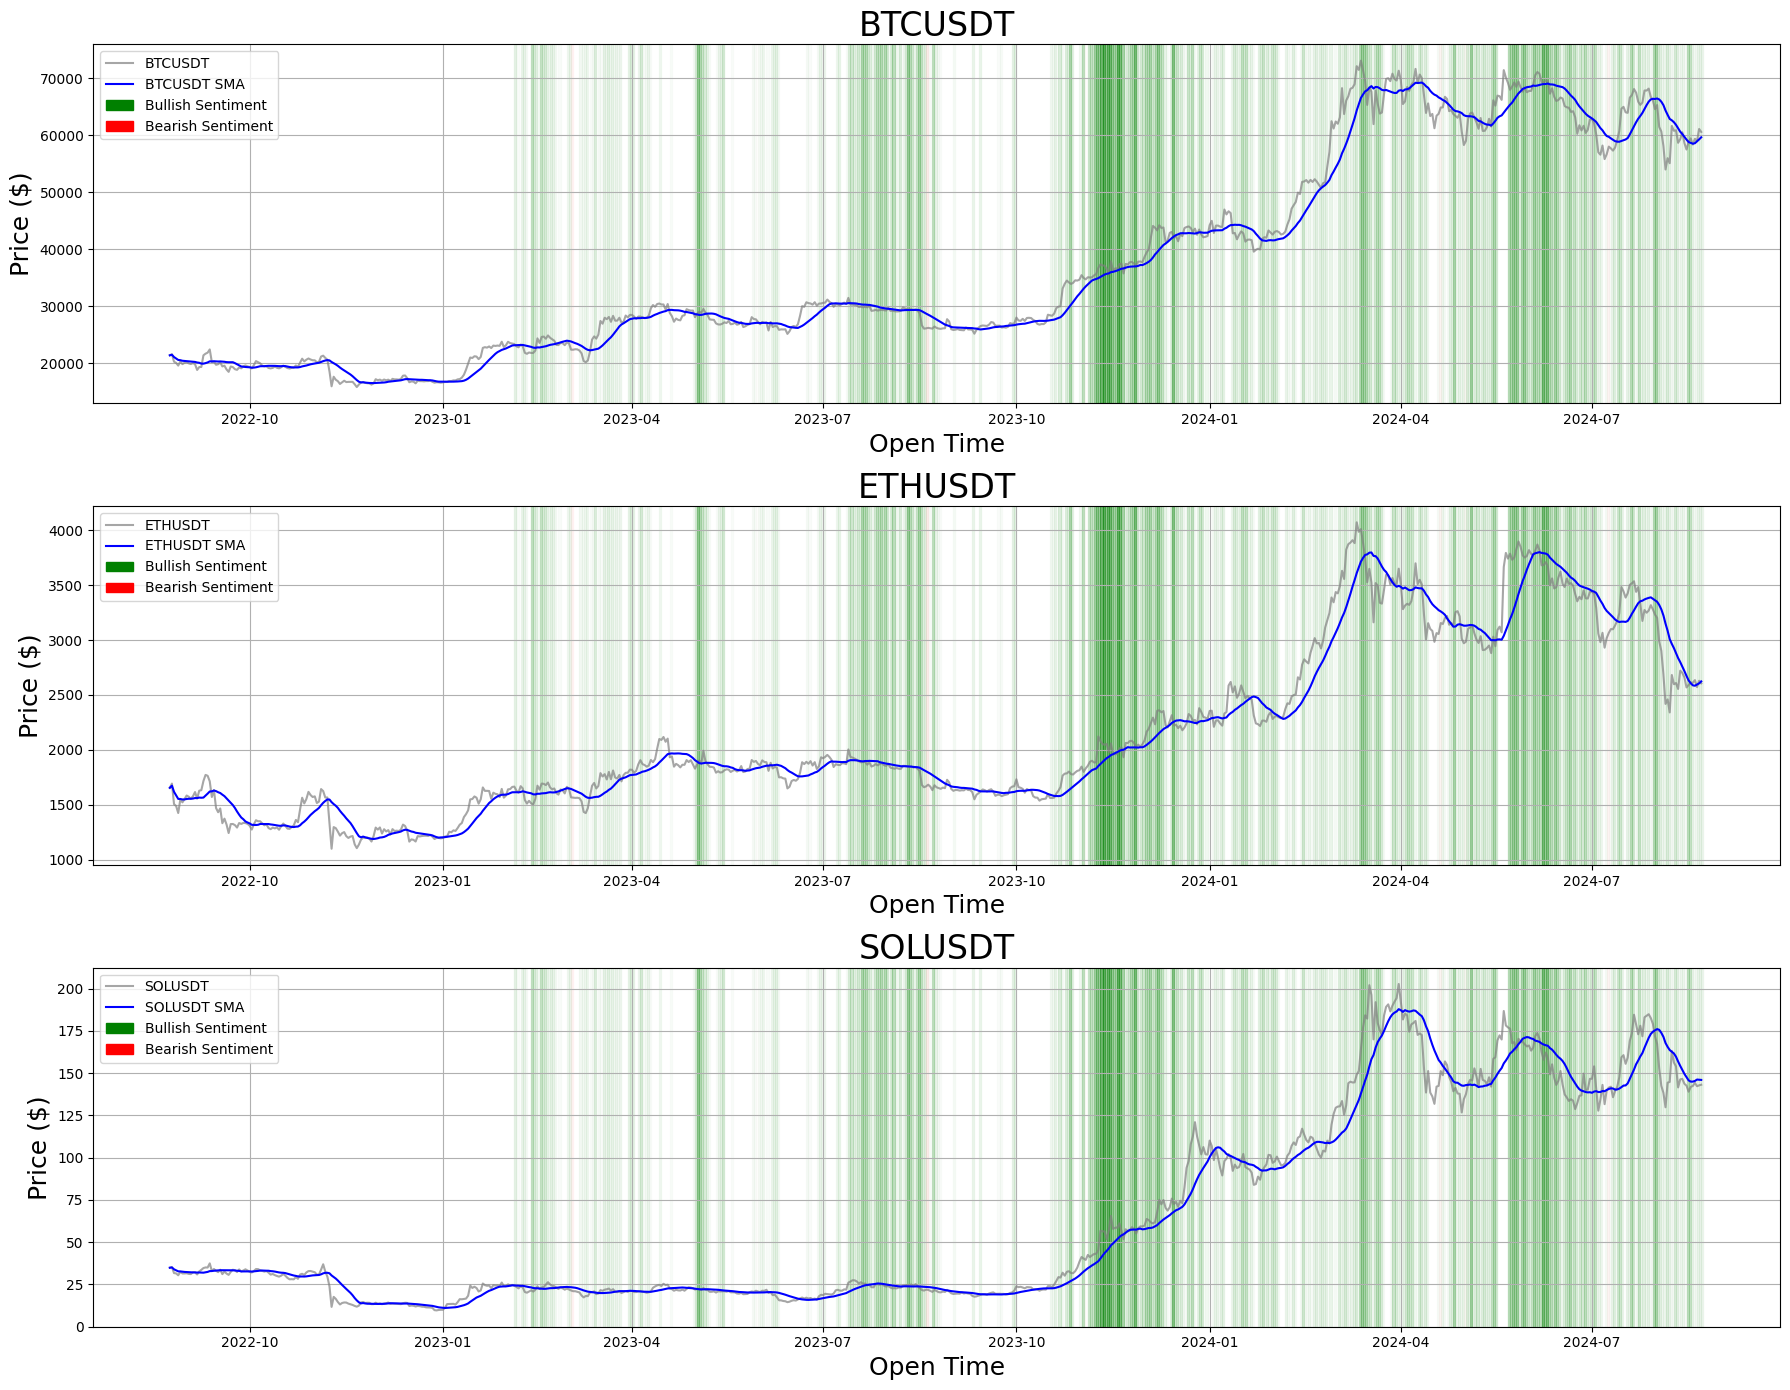

In [38]:
print("\n")

plot_sentiment_on_chart(ticker_pairs, price_data_sanitized, binned_sentiment_score_df)

print("\n")

### Normalised Sentiment Score

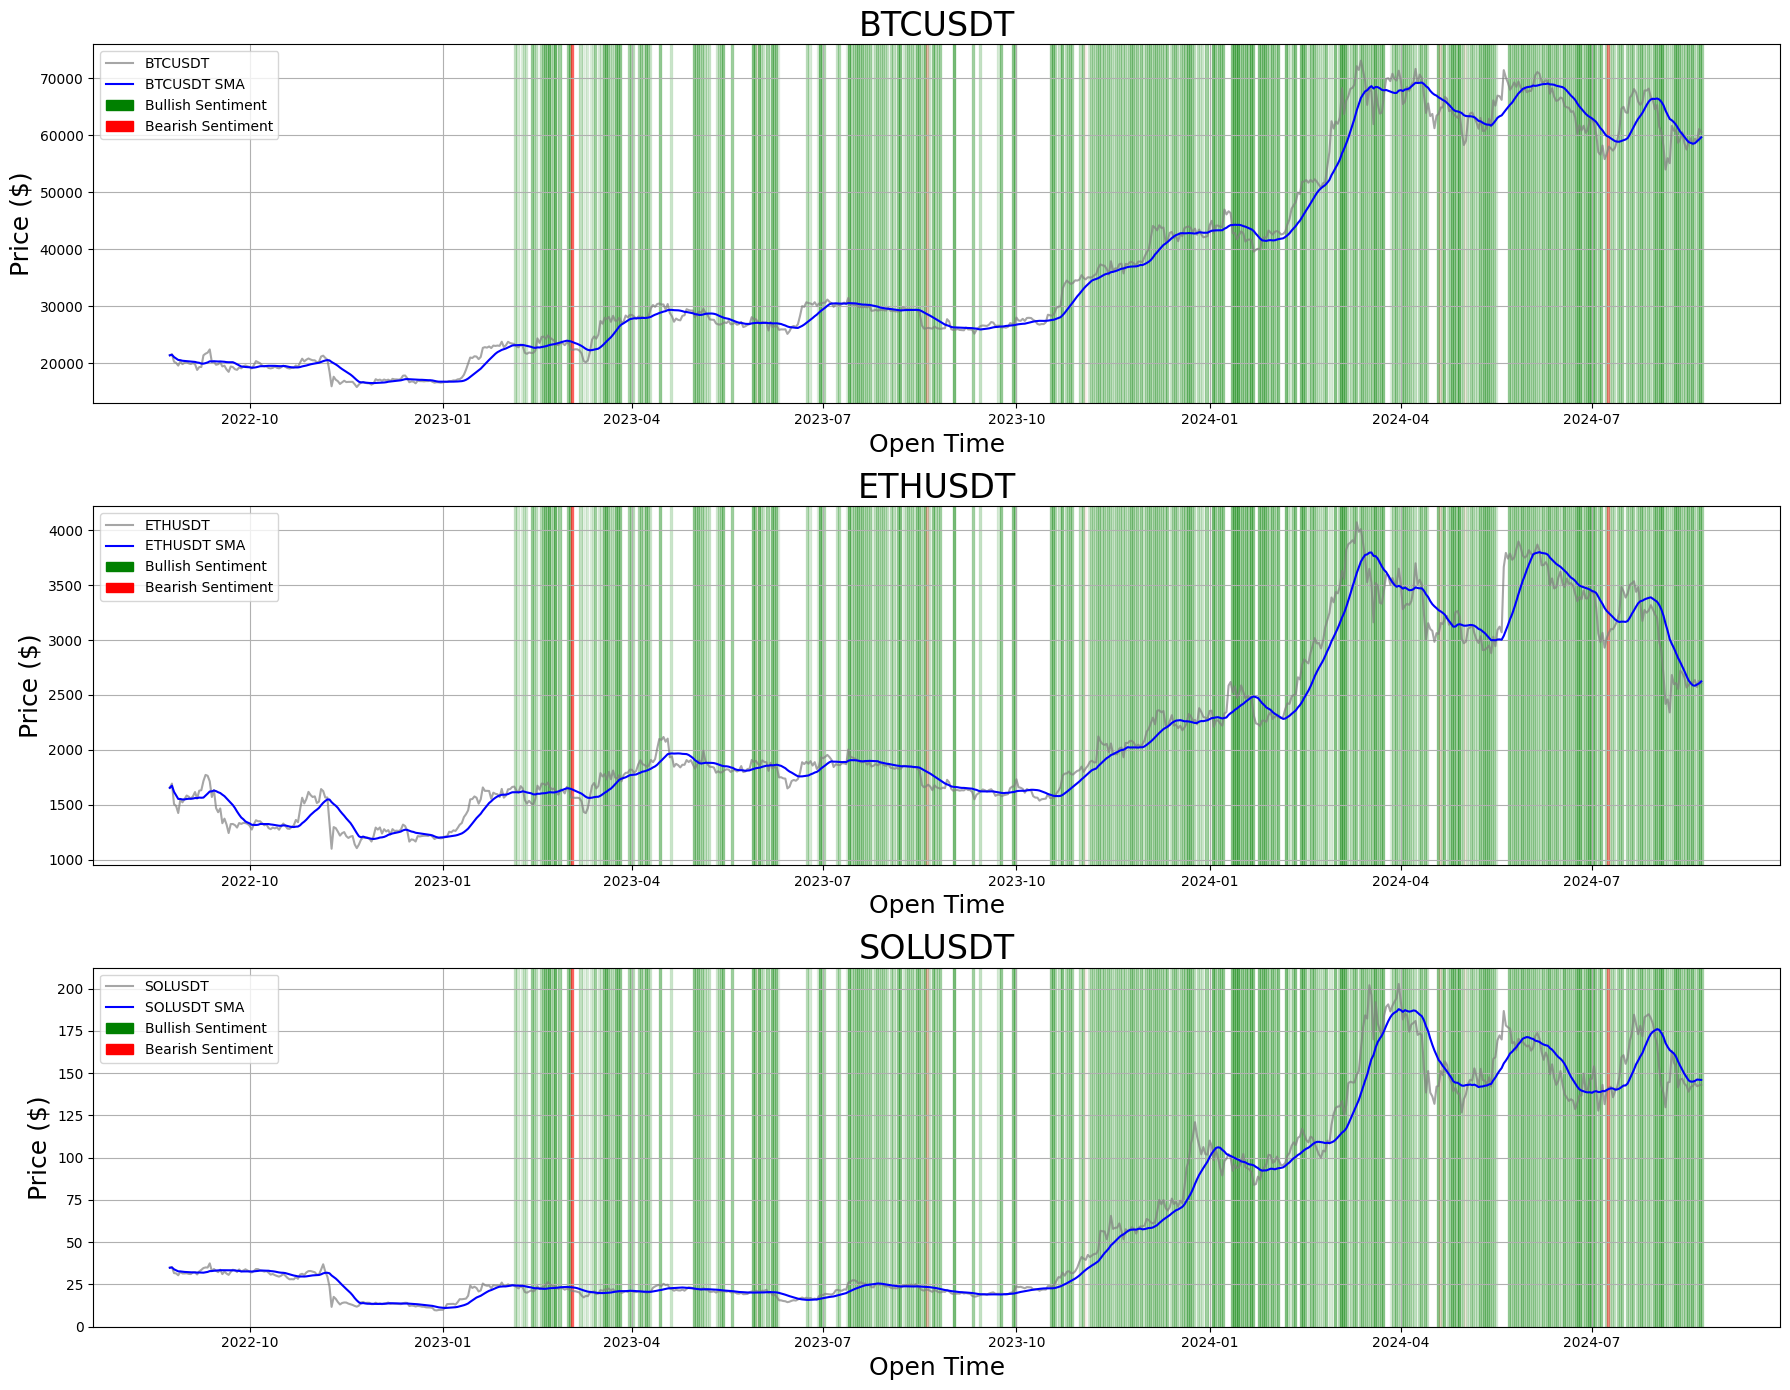

In [39]:
print("\n")

plot_sentiment_on_chart(ticker_pairs, price_data_sanitized, binned_normalised_sentiment_score_df)

print("\n")